In [8]:

import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [4]:
df = pd.read_excel('SPNratios_longformat.xlsx')

In [9]:
df

,Treatment,YFP,CFP,Ratio,Experiment_Date
0,control,65.311,38.009,1.718304,42622
1,control,67.572,38.168,1.770384,42622
2,control,87.111,48.453,1.797845,42622
3,control,70.558,40.561,1.739553,42622
4,control,64.270,37.717,1.704006,42622
...,...,...,...,...,...
140,GBZ,197.930,106.601,1.856737,71622
141,GBZ,87.468,51.210,1.708026,71622
142,GBZ,103.166,65.866,1.566301,71622
143,GBZ,81.675,48.241,1.693062,71622


51

In [21]:
control_data=df[df.Treatment=='control']
GBZ_data=df[df.Treatment=='GBZ']

scipy.stats.mannwhitneyu(control_data,GBZ_data)


TypeError: '<' not supported between instances of 'float' and 'str'

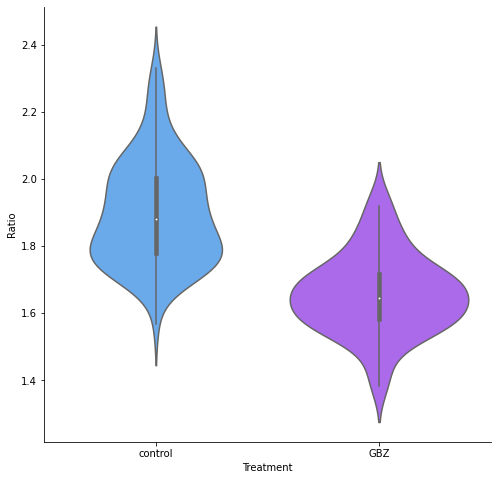

In [60]:
plt.figure(figsize=(8,8))
sns.violinplot(data=df, x='Treatment', y='Ratio', palette='cool')
sns.despine()
plt.savefig('Clom_SPNs_violin.svg', format='svg', dpi=1200)

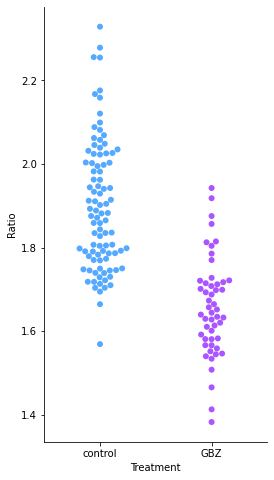

In [59]:
plt.figure(figsize=(4,8))
sns.swarmplot(data=df, x='Treatment', y='Ratio', palette='cool',size=6)
sns.despine()
plt.savefig('Clom_SPNs_swarm.svg', format='svg', dpi=1200)

In [14]:
print('The mean of GBZ ratios is: ' + str(df[df.Treatment == 'GBZ'].Ratio.mean()))
print('The mean of control ratios is: ' + str(df[df.Treatment == 'control'].Ratio.mean()))

The mean of GBZ ratios is: 1.6568489162840565
The mean of control ratios is: 1.8979111529529298


## THIS NEXT CELL IS THE ONE THAT RUNS THE HIERARCHICAL BOOTSTRAP TEST 

In [30]:
#First, prep the dataset into structured arrays that match up with my code

Exp_date_array = df.Experiment_Date.unique()

ctrl_temp = []
gbz_temp = []

for a in Exp_date_array:
    temparray = []
    temparray = df[df.Experiment_Date == a]
    
    if temparray.Treatment.unique()[0] == 'control':
        ctrl_temp.append(np.asarray(temparray.Ratio))
    elif temparray.Treatment.unique()[0] == 'GBZ':
        gbz_temp.append(np.asarray(temparray.Ratio))

#Now resample the dataset a bunch of times and generate matrices that will be used in the next step:
nboot = 10000 #Number of times to resample, keep at 10,000

#Matrix #1 is for control 
bootstrapping_matrix1 = np.zeros([nboot,1,len(ctrl_temp)])
for a in np.arange(0,len(ctrl_temp)): #loop thru number of individuals
    temp = []
    temp = ctrl_temp[a]
    for n in np.arange(0,nboot):
        bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0] #randomly select datapoint from this individual
   
#Matrix #2 is for GBZ 
bootstrapping_matrix2 = np.zeros([nboot,1,len(gbz_temp)])
for a in np.arange(0,len(gbz_temp)): #loop thru number of te4 animals
    temp = []
    temp = gbz_temp[a]
    for n in np.arange(0,nboot):
        bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]

#Now randomly resample your matrices you made 
nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
bootstats1 = np.zeros([nboot2,1])
bootstats2 = np.zeros([nboot2,1])

for n in np.arange(0,nboot2):
    temp_sampled_individuals = []
    temp_sampled_individuals = choices(np.arange(0,len(ctrl_temp)), k=3) #First resample at level of individual

    tempdata = []
    for t in np.arange(0,len(temp_sampled_individuals)):

        temp_pulls = choices(np.arange(0,nboot), k=nboot) #then pull datapoints from individual
        tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_sampled_individuals[t]])

    bootstats1[n] = np.nanmean(tempdata)

for n in np.arange(0,nboot2):
    temp_sampled_individuals = []
    temp_sampled_individuals = choices(np.arange(0,len(gbz_temp)), k=3)

    tempdata = []
    for t in np.arange(0,len(temp_sampled_individuals)):

        temp_pulls = choices(np.arange(0,nboot), k=nboot)
        tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_sampled_individuals[t]])
        
    bootstats2[n] = np.nanmean(tempdata)
    
bootstats1 = bootstats1.flatten()
bootstats2 = bootstats2.flatten()

bootstats_df = pd.DataFrame({'Control': bootstats1, 'GBZ': bootstats2})


#IMPORTANT: bootstats is the list of resampled means for each treatment condition

#Up next is how we measure the p value for significance for comparing the means of the two conditions

sample1 = bootstats1
sample2 = bootstats2

joint_low_val = np.min([np.min(sample1), np.min(sample2)])
joint_high_val = np.max([np.max(sample1), np.max(sample2)])

p_joint_matrix = np.zeros([100,100])

p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
edge_shift = (p_axis[1] - p_axis[0])/2 
p_axis_edges = p_axis - edge_shift
p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)

for i in np.arange(0, np.shape(p_joint_matrix)[0]):
    for j in np.arange(0,np.shape(p_joint_matrix)[1]):
        p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

#p_joint_matrix
p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
p_test = sum(sum(np.triu(p_joint_matrix)));


print(f'The p value for comparing conditions is:{p_test}')  
#report the p value using number of samples

The p value for comparing conditions is:0.0


In [65]:
print('The mean for control treatment of the resampled dataset is: ' + str(np.mean(bootstats1)))
print('The mean for GBZ treatment of the resampled dataset is: ' + str(np.mean(bootstats2)))
print('The std dev for control treatment of the resampled dataset is: ' + str(np.std(bootstats1)))
print('The std dev for GBZ treatment of the resampled dataset is: ' + str(np.std(bootstats2)))


The mean for control treatment of the resampled dataset is: 1.8992957133070434
The mean for GBZ treatment of the resampled dataset is: 1.6495067380225512
The std dev for control treatment of the resampled dataset is: 0.06763128772918164
The std dev for GBZ treatment of the resampled dataset is: 0.03972905495851608


## IMPORTANT REMINDER THAT THE STD DEV OF THE RESAMPLED DATASET IS EQUIVALENT TO THE STD ERROR OF THE MEAN OF YOUR DATA, SO THAT IS WHAT IS USED FOR THE ERROR BARS IN THE FOLLOWING PLOTS!

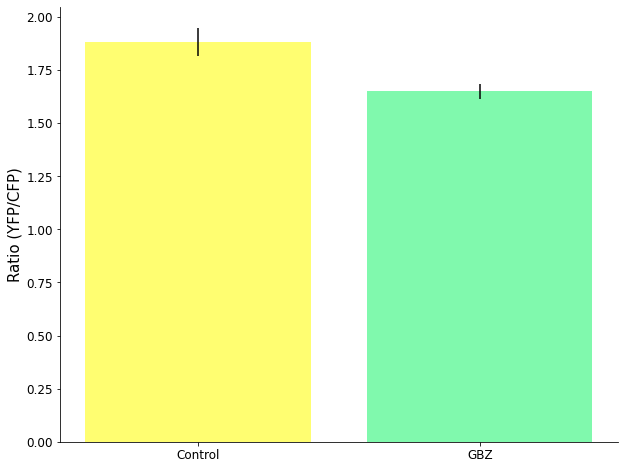

In [57]:
plt.figure(figsize=(10,8))
plt.bar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], color=[sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])
plt.errorbar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], [np.std(bootstats1), np.std(bootstats2)], linestyle='none', color = 'black')

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
sns.despine()

plt.savefig('Bootstrap_Clom_SPNs_bar.svg', format='svg', dpi=1200)



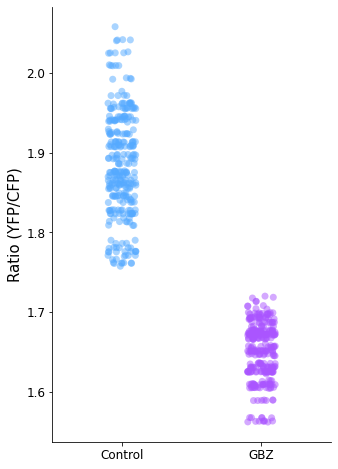

In [56]:

plt.figure(figsize=(5,8))

sns.stripplot( data=[bootstats1,bootstats2], jitter=True, dodge=True, size=7, palette = 'cool', alpha = 0.5)#,color=[sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
sns.despine()

plt.savefig('Bootstrap_Clom_SPNs_strip.svg', format='svg', dpi=1200)

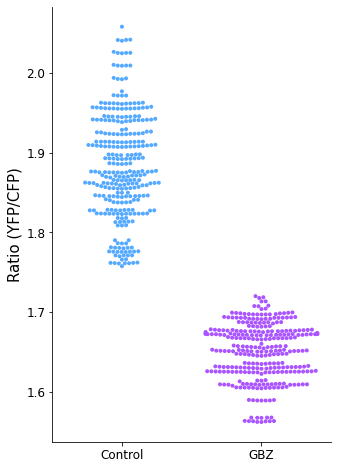

In [54]:
plt.figure(figsize=(5,8))
sns.swarmplot(data=bootstats_df, size=4, palette = 'cool')
plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
sns.despine()
plt.savefig('Bootstrap_Clom_SPNs_swarm.svg', format='svg', dpi=1200)

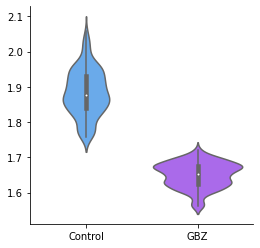

In [55]:
plt.figure(figsize=(4,4))
sns.violinplot(data= bootstats_df, palette='cool')
sns.despine()
plt.savefig('Bootstrap_Clom_SPNs_violin.svg', format='svg', dpi=1200)

In [32]:
bootstats_df

,Control,GBZ
0,1.845460,1.667328
1,1.956915,1.686965
2,1.846191,1.630271
3,1.855671,1.563243
4,1.971816,1.567294
...,...,...
295,1.909621,1.685788
296,1.766369,1.697224
297,1.925606,1.605306
298,1.762244,1.673351


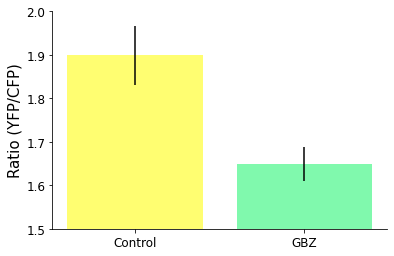

In [127]:
plt.figure(figsize=(6,4))
plt.bar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], color=[sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])
plt.errorbar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], [np.std(bootstats1), np.std(bootstats2)], linestyle='none', color = 'black')

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
plt.ylim(1.5,2)
sns.despine()

#plt.savefig('GBZ_vs_control_Ratio_BootstrapTest_ylim.pdf')



## Here's a box and whisker plot, I think they're nice

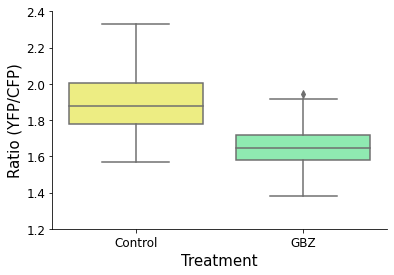

In [126]:
sns.boxplot(data=df, x="Treatment", y="Ratio", palette = [sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Treatment', fontsize=15)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
plt.ylim(1.2,2.4)
sns.despine()

#plt.savefig('GBZ_vs_control_Ratio_BoxAndWhisker.pdf')

## Here I'm just playing around with different ways of plotting your data

In [103]:
bootstats_df = pd.DataFrame({'Control': bootstats1, 'GBZ': bootstats2})
bootstats_df = pd.melt(bootstats_df)

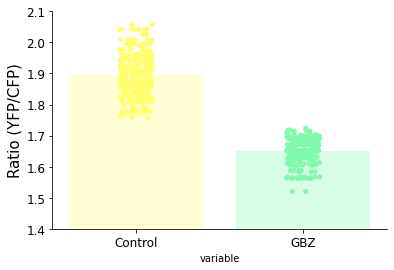

In [124]:
plt.figure(figsize=(6,4))
plt.bar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], color=[sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']], alpha=0.3)
#plt.errorbar([0,1], [np.mean(bootstats1), np.mean(bootstats2)], [np.std(bootstats1), np.std(bootstats2)], linestyle='none', color = 'black')
sns.stripplot(data=bootstats_df, x="variable", y="value", palette = [sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
plt.ylim(1.4,2.1)
sns.despine()

#plt.savefig('GBZ_vs_control_Ratio_BootstrapTest_ylim.pdf')


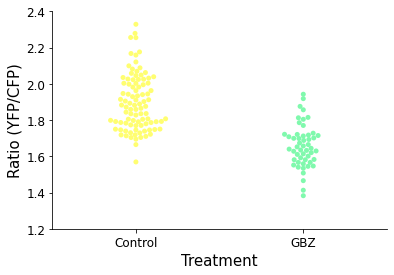

In [119]:
sns.swarmplot(data=df, x="Treatment", y="Ratio", palette = [sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Treatment', fontsize=15)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
plt.ylim(1.2,2.4)
sns.despine()

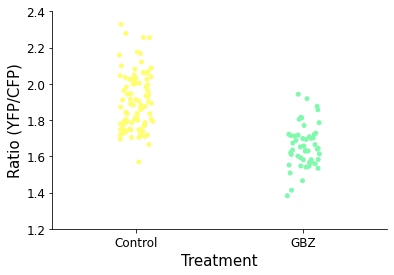

In [120]:
sns.stripplot(data=df, x="Treatment", y="Ratio", palette = [sns.xkcd_rgb['pastel yellow'], sns.xkcd_rgb['seafoam']])

plt.xticks([0,1],['Control','GBZ'],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Treatment', fontsize=15)
plt.ylabel('Ratio (YFP/CFP)', fontsize=15)
plt.ylim(1.2,2.4)
sns.despine()